# Projeto Spark

A ser realizado individualmente.

Entrega: 17 de junho de 2022


In [5]:
pip install WordCloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.6/363.6 kB 4.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import math
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS


In [7]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

In [8]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário. Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [9]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('train.csv').map(parse_line)

In [10]:
rdd.count()

3600000

In [11]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

In [7]:
rdd.saveAsPickleFile('reviews.pickle')

Py4JJavaError: An error occurred while calling o54.saveAsObjectFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory file:/home/jovyan/work/reviews.pickle already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:299)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:71)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1061)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.SequenceFileRDDFunctions.$anonfun$saveAsSequenceFile$1(SequenceFileRDDFunctions.scala:66)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.SequenceFileRDDFunctions.saveAsSequenceFile(SequenceFileRDDFunctions.scala:51)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsObjectFile$1(RDD.scala:1587)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.saveAsObjectFile(RDD.scala:1587)
	at org.apache.spark.api.java.JavaRDDLike.saveAsObjectFile(JavaRDDLike.scala:566)
	at org.apache.spark.api.java.JavaRDDLike.saveAsObjectFile$(JavaRDDLike.scala:565)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsObjectFile(JavaRDDLike.scala:45)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [12]:
rdd = sc.pickleFile('reviews.pickle')

In [13]:
rdd.count()

3600000

In [14]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [15]:
def sepPalRDD(rdd):
    def separaPalavras(line):
        fullLine = line[1] + line[2]
        line_split = fullLine.replace(".", "")
        line_split = line_split.split(" ")
        touple = []
        for i in line_split:
            if len(i) > 2:
                touple.append((i, 1))
        return touple
    rdd_palavra_contagem = rdd.flatMap(separaPalavras).reduceByKey(lambda x, y: x + y)
    return rdd_palavra_contagem

rdd_palavra_contagem = sepPalRDD(rdd)
rdd_palavra_contagem.take(10)


[('out', 731928),
 ('like', 940934),
 ('heart-rendering', 20),
 ('family', 72969),
 ('book', 1607330),
 ('let', 73254),
 ('wasting', 8569),
 ('spelling', 3042),
 ('comedyWhen', 12),
 ('years,', 24059)]

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [16]:
numPalavras = 10e7

def calcProbRDD(rdd_palavra_contagem, numPalavras):
    
    contagemPalavras = rdd_palavra_contagem.map(lambda x: x[1]).reduce(lambda x, y: x+y)
    
    def calculaProbabilidade(line, contagemPalavras, numPalavras):
        prob = math.log10(((line[1]+1)/(contagemPalavras + numPalavras)))
        return (line[0], prob)
    
    rdd_palavra_probabilidade = rdd_palavra_contagem.map(lambda x : calculaProbabilidade(x, contagemPalavras, numPalavras))
    
    return rdd_palavra_probabilidade


In [17]:
rdd_palavra_probabilidade_geral = calcProbRDD(sepPalRDD(rdd), numPalavras)
rdd_palavra_probabilidade_geral.take(10)

[('out', -2.640726965350714),
 ('like', -2.531636296870891),
 ('heart-rendering', -7.182976625440595),
 ('family', -3.6420515739218473),
 ('book', -2.299090599309727),
 ('let', -3.6403586474855527),
 ('wasting', -4.572215098251316),
 ('spelling', -5.0218939678163474),
 ('comedyWhen', -7.391252567867678),
 ('years,', -4.123900297170689)]

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [18]:
rdd_positivo = sepPalRDD(rdd.filter(lambda x: x[0] == 2))
rdd_palavra_probabilidade_positivo = calcProbRDD(rdd_positivo, numPalavras)
rdd_palavra_probabilidade_positivo.take(10)

[('out', -2.8020356217865956),
 ('like', -2.668110822379096),
 ('heart-rendering', -7.034465938835813),
 ('book', -2.399112902158013),
 ('let', -3.83999541565773),
 ('comedyWhen', -7.234038293741017),
 ('years,', -4.194525031890803),
 ('age-old', -6.195948244132877),
 ('family', -3.590248511876197),
 ('Steven', -5.139450716651992)]

In [19]:
rdd_negativos = sepPalRDD(rdd.filter(lambda x: x[0] == 1))
rdd_palavra_probabilidade_negativo = calcProbRDD(rdd_negativos, numPalavras)
rdd_palavra_probabilidade_negativo.take(10)

[('family', -4.0272611534877045),
 ('book', -2.435252168773484),
 ('wasting', -4.450177063109274),
 ('spelling', -5.005384070356947),
 ('item', -3.4693913408049246),
 ('out', -2.7210274085957367),
 ('immediateHere', -8.030074932712377),
 ('timbre', -6.473772431945091),
 ('unitThe', -6.210530997170509),
 ('like', -2.632782505386376)]

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [20]:
rdd_join = rdd_palavra_probabilidade_positivo.fullOuterJoin(rdd_palavra_probabilidade_negativo)
dbNaive = rdd_join.collect()

In [21]:
dbNaive[:5]

[('out', (-2.8020356217865956, -2.7210274085957367)),
 ('heart-rendering', (-7.034465938835813, -7.853983673656696)),
 ('age-old', (-6.195948244132877, -6.4618732086453825)),
 ('family', (-3.590248511876197, -4.0272611534877045)),
 ('start', (-3.718407263794637, -3.7922297058507635))]

In [22]:
dbNaive = dict(dbNaive)

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [23]:
contagemPalavrasNeg = rdd_negativos.map(lambda x: x[1]).reduce(lambda x, y: x+y)
contagemPalavrasPos = rdd_positivo.map(lambda x: x[1]).reduce(lambda x, y: x+y)

In [24]:
faseTeste = "I’ve been signed up for a year and haven’t received a single sample for anything. I’d never complain about free unless free meant nothing at all. lol"

def NaiveBayes(frase):
    line_split = frase.replace(".", "")
    line_split = line_split.split(" ")
    probPos = 0
    probNeg = 0
    for i in line_split: 
        if len(i) > 2:
            if dbNaive[i][0] != None:
                probPos += dbNaive[i][0]
            else:
                probPos += math.log10(1/(contagemPalavrasPos + numPalavras))
                
                
            if dbNaive[i][1] != None:  
                probNeg += dbNaive[i][1]
            else:
                probPos += math.log10(1/(contagemPalavrasNeg + numPalavras))
                
                
    if probPos > probNeg:
        return "Esse é um commentario positívo"
    else:
        return "Esse é um commentario negativo"

NaiveBayes(faseTeste)

'Esse é um commentario negativo'

### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [25]:
def tiraNone(line):
    cpos, cneg = line[1]
    if cpos == None:
        cpos = math.log10(1/(contagemPalavrasPos + numPalavras))
    if cneg == None:
        cneg = math.log10(1/(contagemPalavrasNeg + numPalavras))
    return (line[0], (cpos, cneg))

rdd_join_clean = rdd_join.map(tiraNone)


In [26]:
def calculaDif(line):
    return line[0], (line[1][0] - line[1][1])

rdd_dif = rdd_join_clean.map(calculaDif)
rdd_dif.take(10)

[('out', -0.08100821319085894),
 ('heart-rendering', 0.8195177348208835),
 ('age-old', 0.26592496451250547),
 ('family', 0.43701264161150766),
 ('start', 0.07382244205612665),
 ('willing', -0.11852750378741206),
 ('Electronics', -0.33608068226406296),
 ('gift', 0.22807645932104048),
 ('Houston', 0.2049282500523999),
 ('southside', 0.3189153842516985)]

In [27]:
top_pos = rdd_dif.takeOrdered(100, key = lambda x : -x[1])
top_neg = rdd_dif.takeOrdered(100, key = lambda x : x[1])


In [28]:
top_pos_sem_log = {}
for i in top_pos:
    newV = 10**i[1]
    top_pos_sem_log[i[0]] =  newV
    
top_neg_sem_log = {}
for i in top_neg:
    newV = 10**i[1]
    top_neg_sem_log[i[0]] =  newV


In [29]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

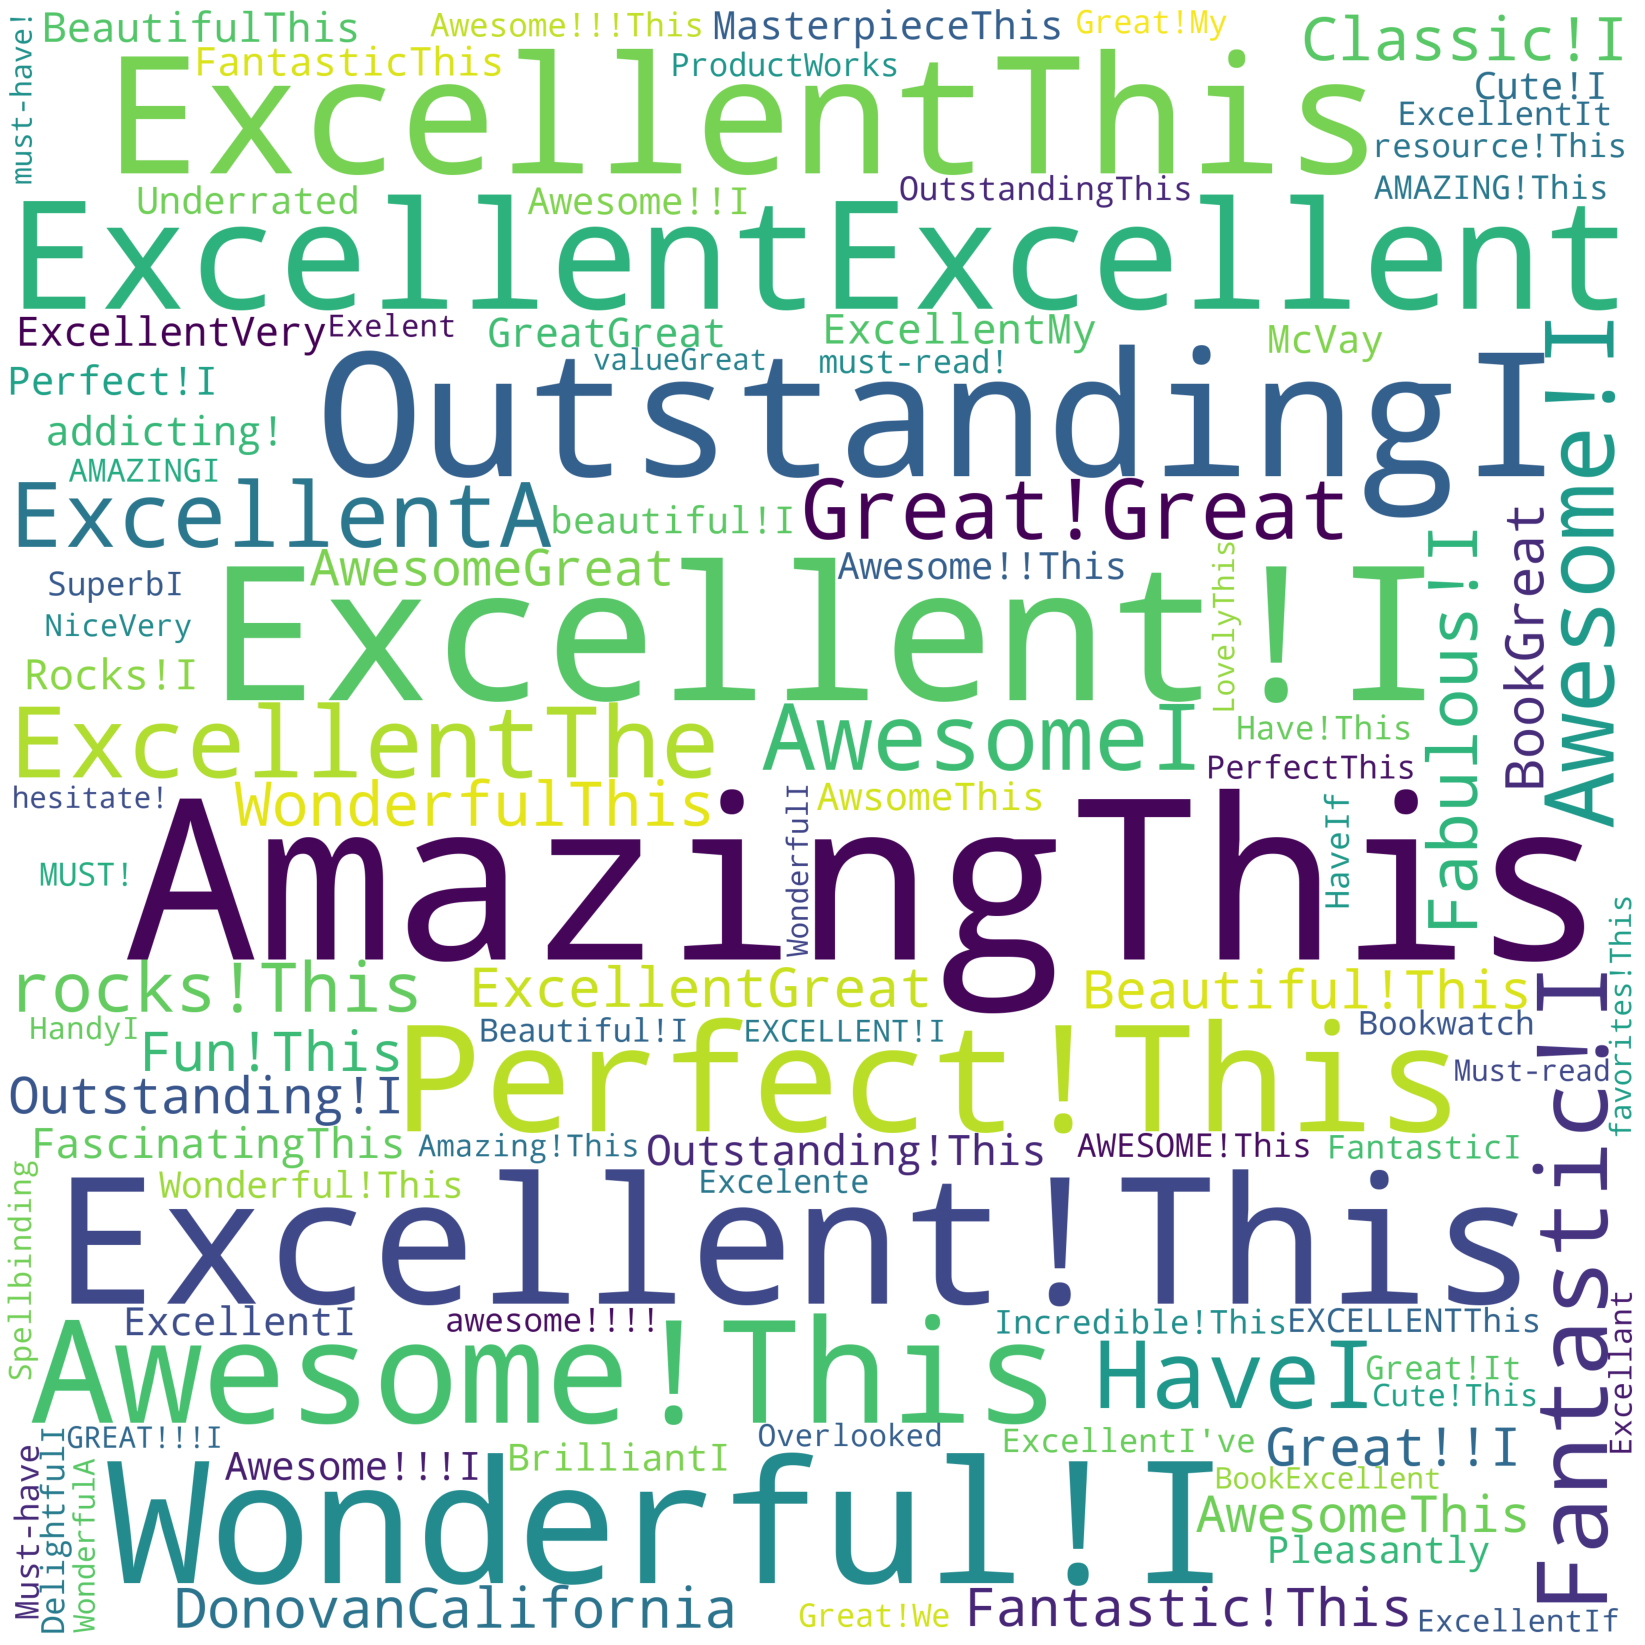

In [30]:
wc = WordCloud(background_color='white', width = 3000, height=3000, margin=2)

plot_cloud(wc.fit_words(top_pos_sem_log))

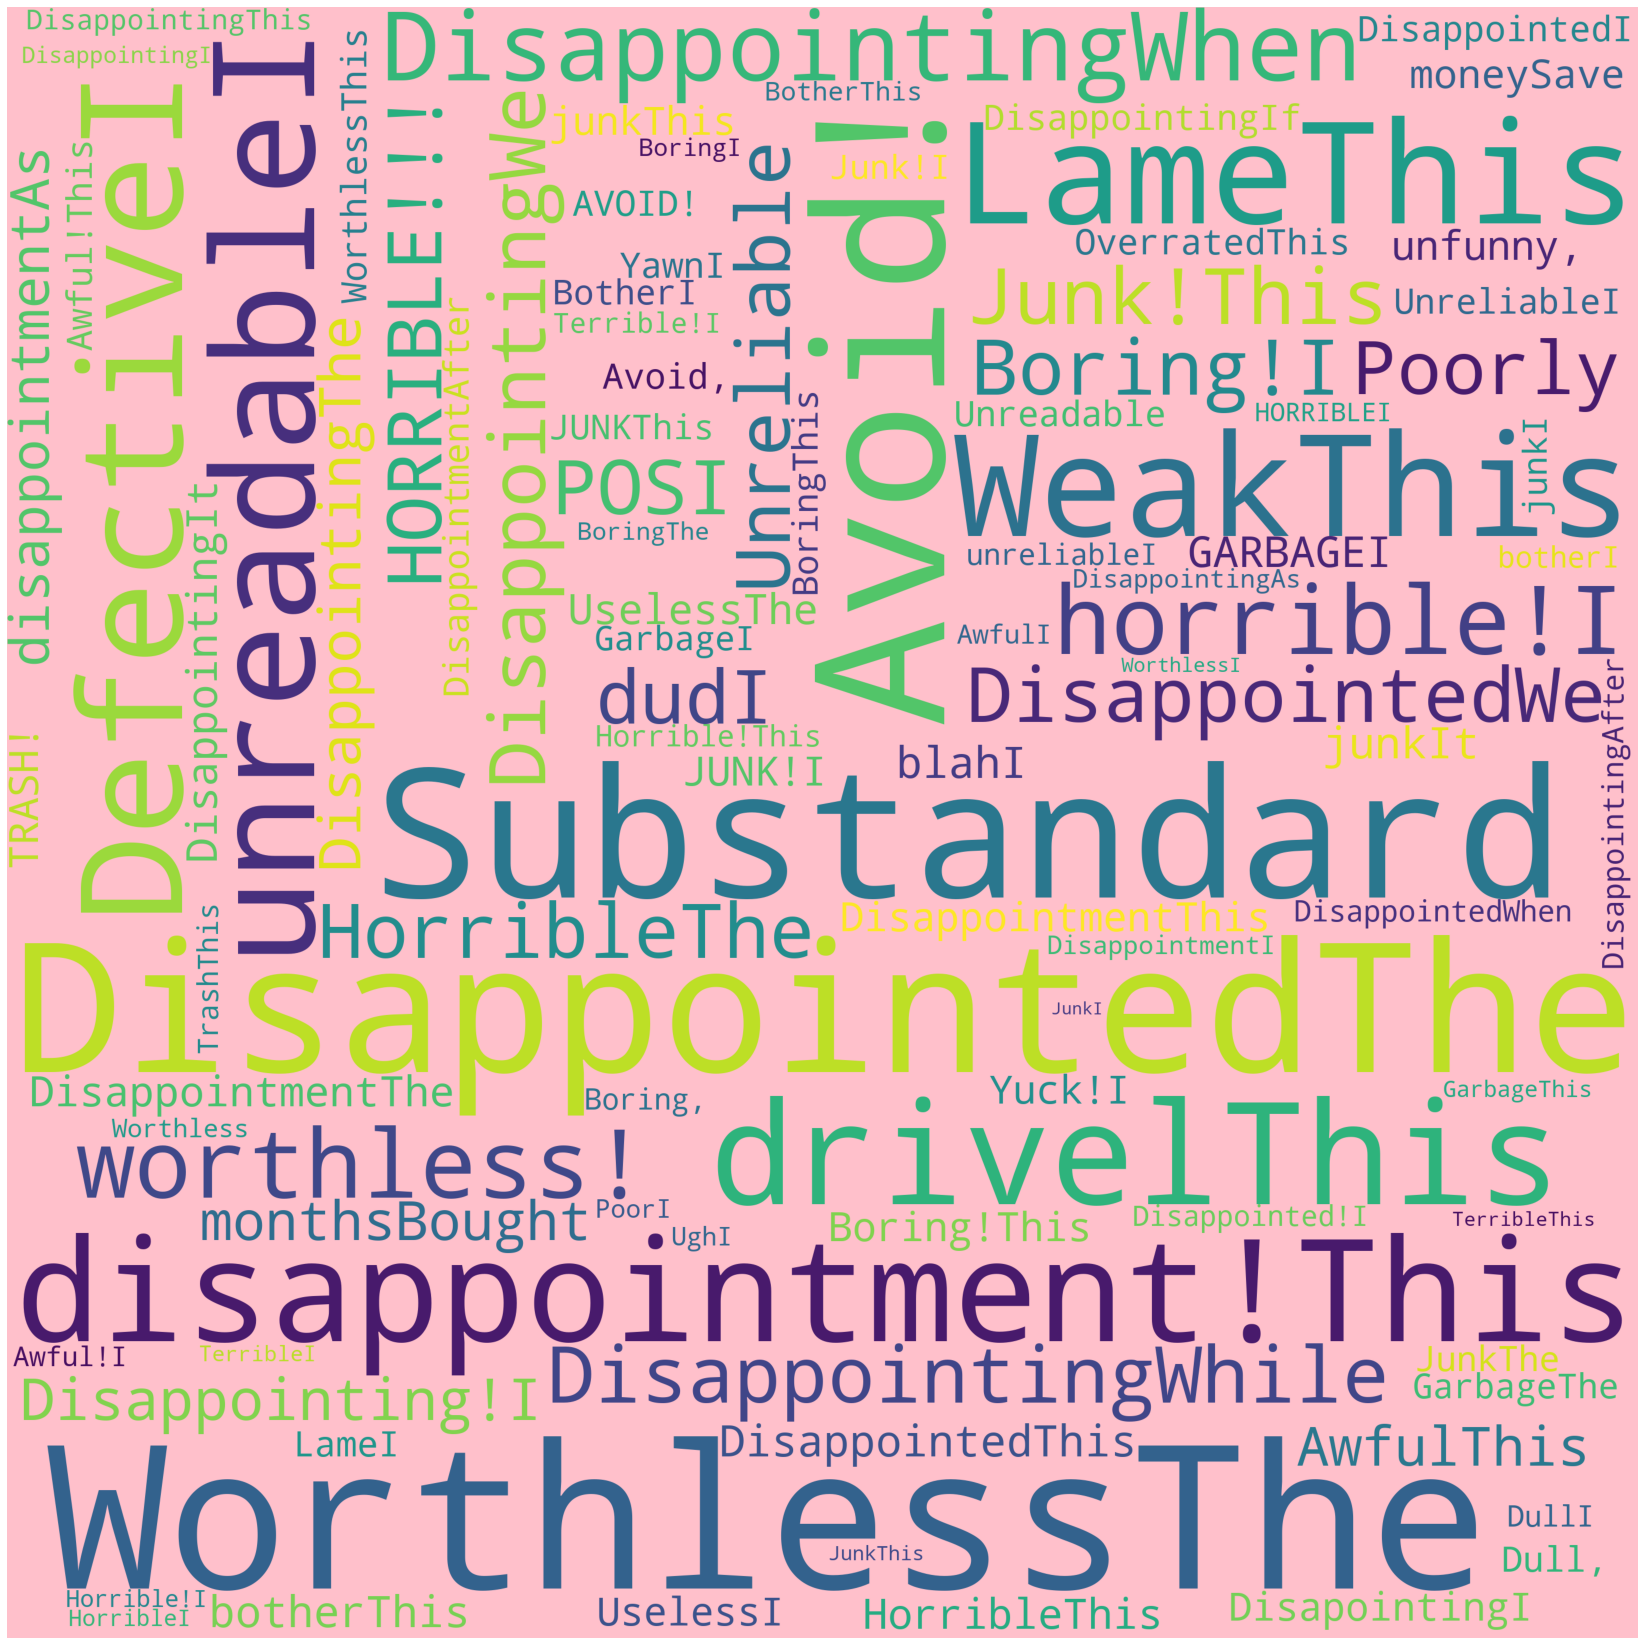

In [34]:
wc = WordCloud(background_color='pink', width = 3000, height=3000, margin=2)

plot_cloud(wc.fit_words(top_neg_sem_log))

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

### Tarefa desafio!

Implemente Laplace smoothing

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa